In [1]:
from osgeo import gdal
import pandas as pd
import os
import numpy as np
import proplot as plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

In [2]:
pth='D:\\Key_works\\20231212dh_calculate\\xnhl_test'
pth_dh=pth+'\\gla_level_dh_final\\nc_yr_mb'

#### 补充统计信息，下次不运行 

In [3]:
df_effe_dxt=pd.read_csv(pth+'\\dh-effe-stat.csv',index_col=0)
df_effe_dxt.head(2)

,group_id,mean,median,mean_fill,median_fill,Glc_Area,Mean_Elev,Mean_Slp,Mean_Asp,MA_Elev,basin
G101096E33298N,g0018,-2.247736,-4.501035,-2.532606,-4.124494,2.930313e+05,4942.3,39.4,315.8,4939.9,Yellow
G101108E33292N,g0018,1.705512,1.456494,1.766449,1.840311,1.968628e+06,4977.4,26.6,40.8,4998.3,Yellow


In [54]:
#flst=os.listdir(pth_dh)
arr=[]
for nm in df_effe_dxt.index:
    nmin=pth_dh+'\\'+nm+'.nc'
    dsi=xr.open_dataset(nmin)
    dherr=dsi.attrs['dh error']
    dh_samp=dsi.attrs['effective samples']
    err=dsi.attrs['mb error']
    dt=(2000-dsi.dxt_id.mean()).values
    if dt>40:dt=30
    mb=dsi['mb'].mean().values
    arr.append([nm,dherr,dh_samp,mb,err,dt])
    #break
df_arr=pd.DataFrame(arr,columns=['id0','dh_error','effe_samples','mb','mb_error','dtime'])

In [55]:
df_arr.mb.mean(),df_arr.mb_error.median()

(-0.31040319417826157, 0.1228)

In [56]:
df_effe_dxt_new=pd.concat([df_effe_dxt,df_arr.set_index('id0')],axis=1)

In [57]:
#df_effe_dxt_new

In [58]:
df_effe_dxt_new.to_csv(pth+'\\dh-effe-stat_more.csv')

#### 统计 

In [59]:
df_effe_dxt_new=pd.read_csv(pth+'\\dh-effe-stat_more.csv',index_col=0)
df_effe_dxt_new.head(2)

,group_id,mean,median,mean_fill,median_fill,Glc_Area,Mean_Elev,Mean_Slp,Mean_Asp,MA_Elev,basin,dh_error,effe_samples,mb,mb_error,dtime
G101096E33298N,g0018,-2.247736,-4.501035,-2.532606,-4.124494,2.930313e+05,4942.3,39.4,315.8,4939.9,Yellow,3.6774,10.5176,-0.057896,0.0948,33.0
G101108E33292N,g0018,1.705512,1.456494,1.766449,1.840311,1.968628e+06,4977.4,26.6,40.8,4998.3,Yellow,1.3081,41.6218,0.043930,0.0338,33.0


In [60]:
dh_err_propa=pd.read_csv(pth+'\\dh_error_propagation.csv',index_col=0)
for i in dh_err_propa.group:
    df_effe_dxt_new.loc[df_effe_dxt_new['group_id']==i,'dh_propa_err']=dh_err_propa[dh_err_propa.group==i]['error_1sigma'].values[0]

In [4]:
gla_pth=pth+'/shp/gla_cgi1_basin.gpkg'
df_gla=gpd.read_file(gla_pth)

##### 不同坡度坡向统计

In [5]:
####dxt_effe_pt  用于统计分析
dxt_effe_pt=df_effe_dxt_new.loc[:,['mean','median','dh_error','Glc_Area','Mean_Asp','Mean_Slp','MA_Elev']]
dxt_effe_pt.columns=['dh_mean','dh_med','dh_error','area','masp','mslp','mz']
dxt_effe_pt['area']=dxt_effe_pt['area']/1000./1000.  ##转为km2

In [6]:
####统计不同坡度坡向
def stat_asp_slp(dxt_effe0):
    dxt_effe=dxt_effe0*1
    asp_range=np.arange(22.5,361,45)
    asp_sign=['NE','E','SE','S','SW','W','NW','N']
    slp_range=np.arange(0,61,10)
    slp_sign=['0_10','10_20','20_30','30_40','40_50','50_60']
    for i in range(8):
        if i==7:
            #df_con_asp=dxt_effe_pt[(dxt_effe['masp']>337.5) | (dxt_effe['masp']<=22.5)]
            con1=(dxt_effe['masp']>337.5) | (dxt_effe['masp']<=22.5)
        else:
            #df_con_asp=dxt_effe_pt[(dxt_effe_pt['masp']>asp_range[i]) & (dxt_effe_pt['masp']<=asp_range[i+1])]
            con1=(dxt_effe['masp']>asp_range[i]) & (dxt_effe['masp']<=asp_range[i+1])
        dxt_effe.loc[con1,'asp_sign']=asp_sign[i]
        #print(dxt_effe)
        #break
        for j in range(6):
            #df_con=df_con_asp[(df_con_asp['mslp']>=slp_range[j])&(df_con_asp['mslp']<slp_range[j+1])]
            con2=(dxt_effe['mslp']>=slp_range[j])&(dxt_effe['mslp']<slp_range[j+1])
            dxt_effe.loc[con1 & con2,'slp_sign']=slp_sign[j]
    return dxt_effe

In [7]:
import matplotlib as mpl
plt.rcParams['font.size'] = 9
plt.rcParams['font.sans-serif']='times new roman'
def analysis(df,sca,fignm):
    '''apsect  22.5  67.5 坡向顺延22.5，asp+22.5  大于360的为N， 0-45为N，…''' 
    #asp=list(np.arange(0,361,45))
    #slp=np.arange(0,91,10)
    #创建格网
    fig = plt.figure(figsize=(6,4.8))
    ax = fig.add_subplot(111, projection='polar')
    #cmap = plt.get_cmap('RdYlGn_r')
    norm = mpl.colors.Normalize(vmin=-30, vmax=3)
    scc=ax.scatter(df['masp'],df['mslp'],s=df['area']*sca,c=df['dh_mean'],linewidths=0,cmap='gist_heat',norm=norm)
    #ax.set_rorigin(0)
    ax.set_theta_zero_location('N') #设置开始位置
    ax.set_theta_direction(-1)#设置顺时针
    ax.set_rgrids(np.arange(10,49,10))#设置半径范围
    #-----------
    ax.set_thetagrids(np.arange(22.5, 360.0, 45)) #设置网格线
    ax.set_xticklabels('')
    ax.set_ylim(0,50)
    ax.text(0,50,'N')
    ax.text(np.pi/4,50,'NE')
    ax.text(np.pi/2,50,'E')
    ax.text(3*np.pi/4,50+2,'SE')
    ax.text(4*np.pi/4,50+3,'S')
    ax.text(5*np.pi/4,50+3*2,'SW')
    ax.text(6*np.pi/4,50+4,'W')
    ax.text(7*np.pi/4,50+4,'NW')
    ax.text(1*np.pi/8,50,'slope($^\circ$)')
    #--------------------
    #ax.set_rlabel_position('90') #设置半径标注位置
    #ax.set_rlim(0.6,1.2) #设置极坐标半径范围
    
    cbar=fig.colorbar(scc, ax=ax,orientation='vertical',pad=0.05,extendrect=False,\
                 fraction=0.03,extend='both')
    cbar.ax.tick_params(labelsize=7,direction='in',pad=2.2,width=0.5,length=2)
    cbar.set_label('Elevation difference (m)')

    handles, labels = scc.legend_elements(prop="sizes", alpha=0.6,markerfacecolor='gray',markeredgecolor='k')
    legend2 = ax.legend(handles, labels, loc="center left", title="Area(* %s km$^2$)"%(1/sca),markerscale=1,frameon=False,bbox_to_anchor=(-0.26,0.5),labelspacing=1.9)
    #print(dir(legend2))
    #plt.show()
    #print(df['area'].mean())
    plt.savefig(fignm,dpi=600,bbox_inches='tight')

In [14]:
import proplot as pplt
def paint2(hbar_me,hbar_area,slp_sign,asp_sign,mycycle,outnm):
    fig,ax=pplt.subplots(ncols=1,nrows=1,figsize=('16cm','8cm'))

    num=len(slp_sign)
    num_a=len(asp_sign)
    def fun_tt(y,n=num):
        yy=list(y)
        if len(yy)<n:
            for i in range(n-len(yy)):
                yy.append(0)
        else:pass
        return yy
    yall=[];myarea=[]
    for t in asp_sign:
        yi=fun_tt(hbar_me[t].values)
        myarea.append(hbar_area[t])
        yall.append(np.array(yi))
    #####################################################
    axt=ax.twinx() 
    axt.set_zorder(10)

    #cycle = pplt.Cycle(['#edf8fb','#b3cde3','#8c96c6','#88419d'], right=0.8)
    print(np.array(yall).shape)
    lg=ax.bar(range(num_a), np.array(yall), linewidth=0, alpha=0.8, width=0.8,cycle=mycycle)
    axt.scatter(range(num_a),myarea,color='k',alpha=0.6,label='Glacier area (km$^2$)',s=8)
    for i in range(num_a):
        axt.text(i-0.2,myarea[i]-150,str(int(round(myarea[i],0))))

    axt.format(ylim=(100,3000),yticklabels=[],ytickwidth=0)
    ax.format(ylim=(5,-30),xticks=[0,1,2,3,4,5,6,7],xticklabels=asp_sign,ylabel='Elevation difference (m)')
    ax.legend(lg,slp_sign,ncol=6,loc=1,frameon=False)
    #ax.text(1.8,7,'Slope ranges:')
    axt.legend(loc=2,frameon=False)
    plt.savefig(outnm,dpi=600,bbox_inches='tight')

In [9]:
dxt_sta_asp_slp=stat_asp_slp(dxt_effe_pt)

In [10]:
dff_pt=dxt_sta_asp_slp[(dxt_sta_asp_slp.area<300)&(dxt_sta_asp_slp.area>10)]
dff_pt1_10=dxt_sta_asp_slp[(dxt_sta_asp_slp.area<=10)&(dxt_sta_asp_slp.area>1)]

C:\Users\zhuyu\AppData\Local\Temp\ipykernel_33784\983959013.py:35: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=fig.colorbar(scc, ax=ax,orientation='vertical',pad=0.05,extendrect=False,\


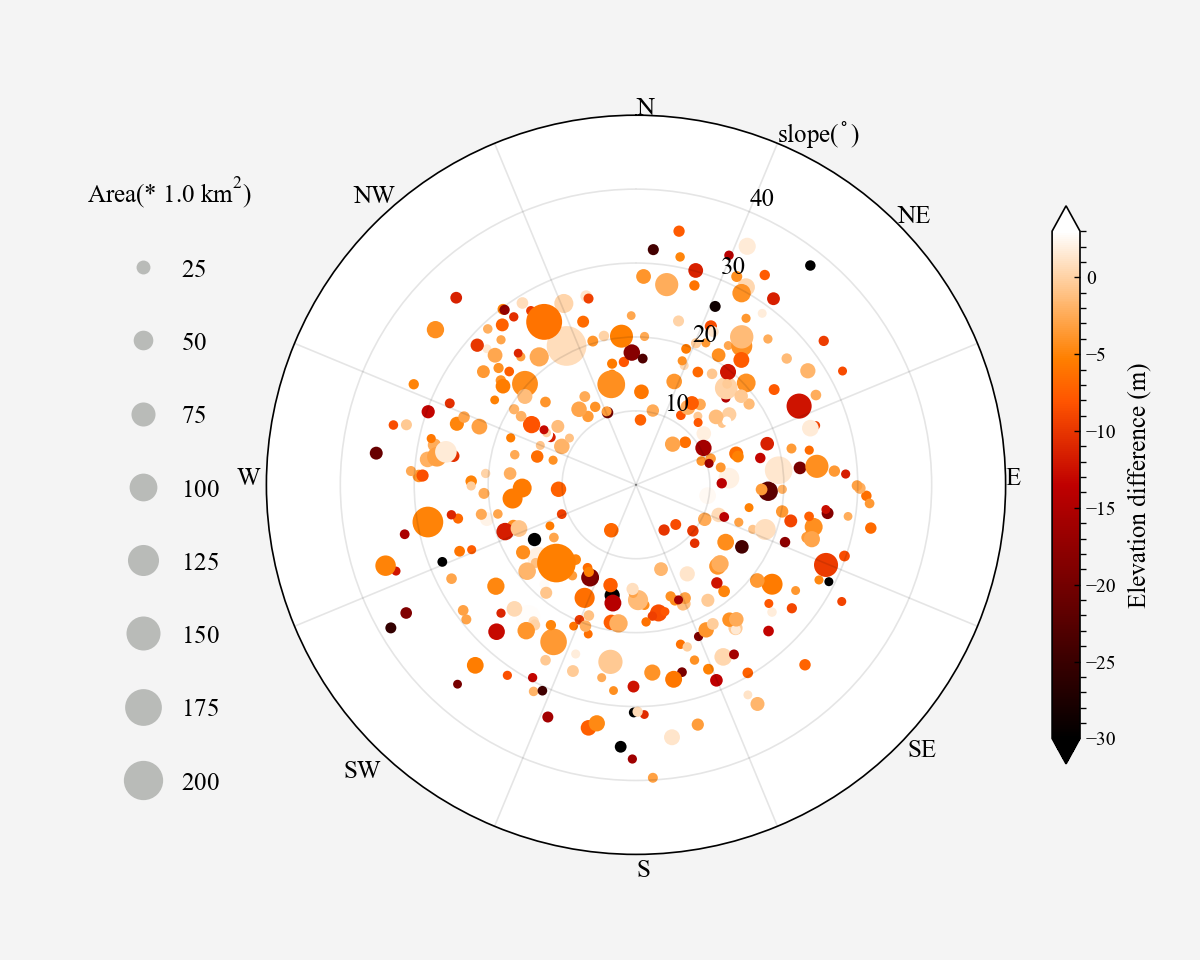

In [19]:
fignm=pth+'/0Figs_paper/Dh-ele_slp_asp_area_ge10-1.svg'
analysis(dff_pt,1,fignm)

In [11]:
hbar_me=dff_pt.groupby(['asp_sign','slp_sign']).mean()['dh_mean']
#hbar_me=hbar_me[hbar_me<0]
hbar_area=dff_pt.groupby(['asp_sign']).sum()['area']

(8, 4)


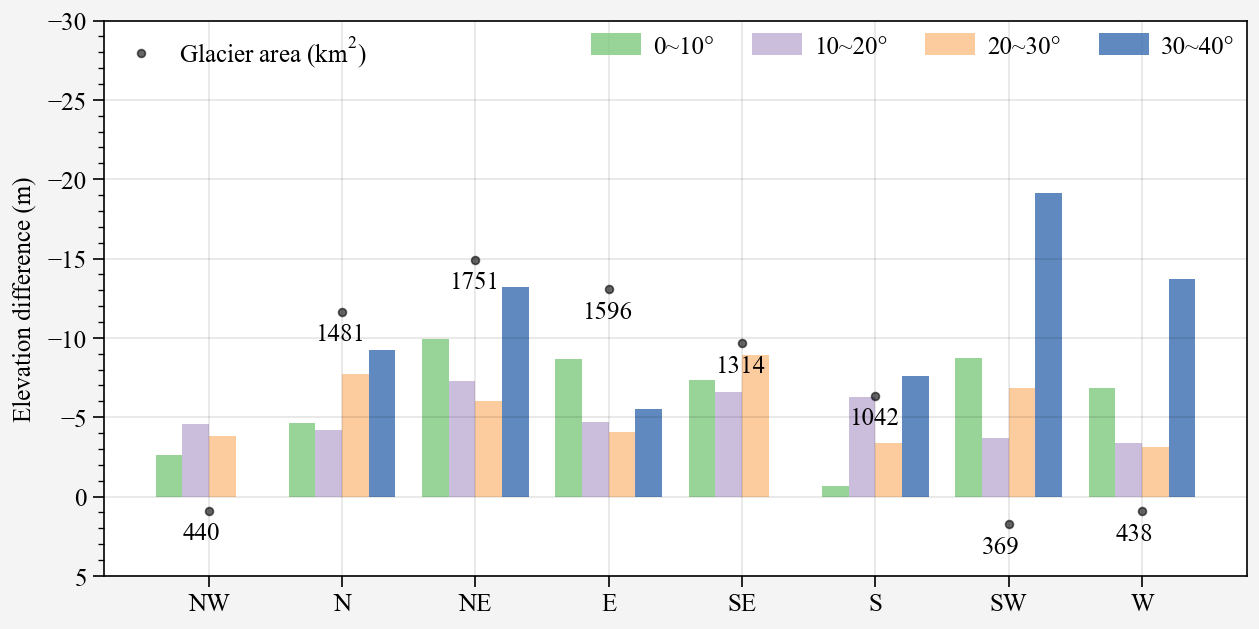

In [15]:
slp_sign=['0~10°','10~20°','20~30°','30~40°']
mycycle=['#7fc97f','#beaed4','#fdc086','#386cb0']
asp_sign=['NW','N','NE','E','SE','S','SW','W']
outnm=pth+'/0Figs_paper/Dh-ele_slp_asp_area_ge10_1-22.svg'
paint2(hbar_me,hbar_area,slp_sign,asp_sign,mycycle,outnm)

In [ ]:
#### 不同规模冰川的dh变化统计
#### 冰川规模参考《中国冰川目录》2005
#### <=0.5  0.5-1 1-5 5-10 10-30 30-50 50-80 80-100 100-300 >=300

In [76]:
rgf=[0,0.5,1,5,10,30,50,80,100,300,1e6]
df_effe_area=dxt_effe_pt*1

In [77]:
df_gla.columns

Index(['Glc_Code', 'Drng_Code', 'Old_Code', 'Glc_Area', 'Max_Elev',
       'Tail_Elev', 'Mean_Elev', 'MA_Elev', 'Mean_Slp', 'Mean_Asp', 'Fst_Src',
       'Fst_Date', 'City', 'Province', 'Mountain', 'Name_Basin', 'Name_W5',
       'RGIId', 'GLIMSId', 'Name', 'core_sign', 'BgnDate', 'EndDate', 'CenLon',
       'CenLat', 'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed',
       'Slope', 'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType',
       'Surging', 'Linkages', 'layer', 'path', 'basin', 'geometry'],
      dtype='object')

In [78]:
df_gla['Area']=df_gla['Glc_Area']/1000./1000.

In [79]:
sta_out=[]
for i in range(10):
    #print(rgf[i],rgf[i+1])
    df_con=df_gla[(df_gla['Area']>rgf[i]) & (df_gla['Area']<=rgf[i+1])]
    df_con_effe=df_effe_area[(df_effe_area['area']>rgf[i]) & (df_effe_area['area']<=rgf[i+1])]
    sta_out.append([len(df_con),df_con['Area'].sum(),len(df_con_effe),df_con_effe['area'].sum(),df_con_effe['dh_mean'].mean()-0.5,df_con_effe['dh_error'].median()])
    #break
rgf_sign=['LE_0.5','0.5-1','1-5','5-10','10-30','30-50','50-80','80-100','100-300','GE_300']
header=['gla_num','gla_area','gla_effe_num','gla_effe_area','dh_mean','dh_error']
df=pd.DataFrame(sta_out,index=rgf_sign,columns=header)
#df.to_csv('dh_scale.csv')

In [80]:
df_effe_area['dh_mean'].mean()

-9.524962689799008

In [22]:
df['gla_effe_num'].sum(),df['gla_num'].sum(),df['gla_effe_num'].sum()/df['gla_num'].sum(),df['gla_effe_area'].sum()/df['gla_area'].sum()

(13117, 24869, 0.527443805541035, 0.7166043550675423)

In [23]:
df_effe_dxt_new['mean'].mean()

-9.524962689799008

##### 纬向特征统计

In [19]:
nc_pth=pth+'\\dh_swr_0.5deg_1970s-2000_v3.nc'
ds_dh1970=xr.open_dataset(nc_pth)
gla_mask=ds_dh1970['gla_flag'].where(ds_dh1970['gla_flag']!=0).values*0+1

In [20]:
gla_ratio=ds_dh1970['gla_ratio']*gla_mask

In [21]:
ds_shp=gpd.read_file(pth+'/shp/Basin_xn.shp')

In [22]:
ds_dh1970

<xarray.Dataset> Size: 94kB
Dimensions:      (x: 60, y: 26)
Coordinates:
  * x            (x) float64 480B 75.25 75.75 76.25 76.75 ... 103.8 104.2 104.8
  * y            (y) float64 208B 39.75 39.25 38.75 38.25 ... 28.25 27.75 27.25
Data variables:
    gla_ratio    (y, x) float64 12kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dh           (y, x) float64 12kB ...
    res_error    (y, x) float64 12kB ...
    gla_flag     (y, x) int32 6kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 0 0 0 0 0 0 0 0 0
    dxt_year     (y, x) float64 12kB ...
    dh_error     (y, x) float64 12kB ...
    mb           (y, x) float64 12kB ...
    mb_error     (y, x) float64 12kB ...
    spatial_ref  int32 4B ...
Attributes:
    transform:      [ 0.5  0.  75.   0.  -0.5 40. ]
    res:            [0.5 0.5]
    nodatavals:     nan
    coords_format:  Grid center
    created date:   2024-02
    institute:      Yunnan University
    authors:        Zhu Yu; Liu Shiyin*
    email:          shiyin.liu@ynu.edu.cn; yuzhu@mail.ynu.edu.cn

In [23]:
###物质平衡
ds_mb=ds_dh1970['mb']
lat_mb=ds_mb.mean(axis=1).to_dataframe()
lon_mb=ds_mb.mean(axis=0).to_dataframe()
gla_lat=gla_ratio.sum(axis=1).to_dataframe()/60
gla_lon=gla_ratio.sum(axis=0).to_dataframe()/26

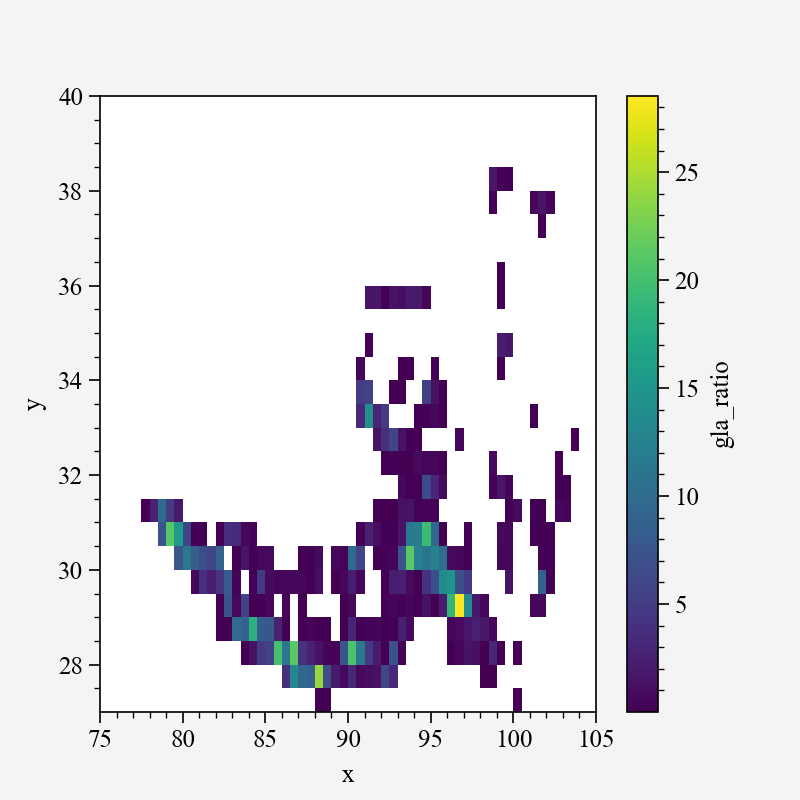

In [26]:
gla_ratio.plot()

In [25]:
###cartopy 使用google地图需要翻墙，使用geemap自带的
import geemap
geemap.set_proxy('10809')

C:\Miniconda3\envs\py39\lib\site-packages\cartopy\mpl\geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Miniconda3\envs\py39\lib\site-packages\cartopy\mpl\geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\Users\zhuyu\AppData\Local\Temp\ipykernel_36440\1046906574.py:17: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.add_image(tiler1,7,alpha=0.7)
C:\Users\zhuyu\AppData\Local\Temp\ipykernel_36440\1046906574.py:26: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 0}
  sc=axs[1].pcolor(gla_ratio,cmap='Deep',extend='max',vmin=0,levels=[0,1,2,3,4,5,10,15,20,30]

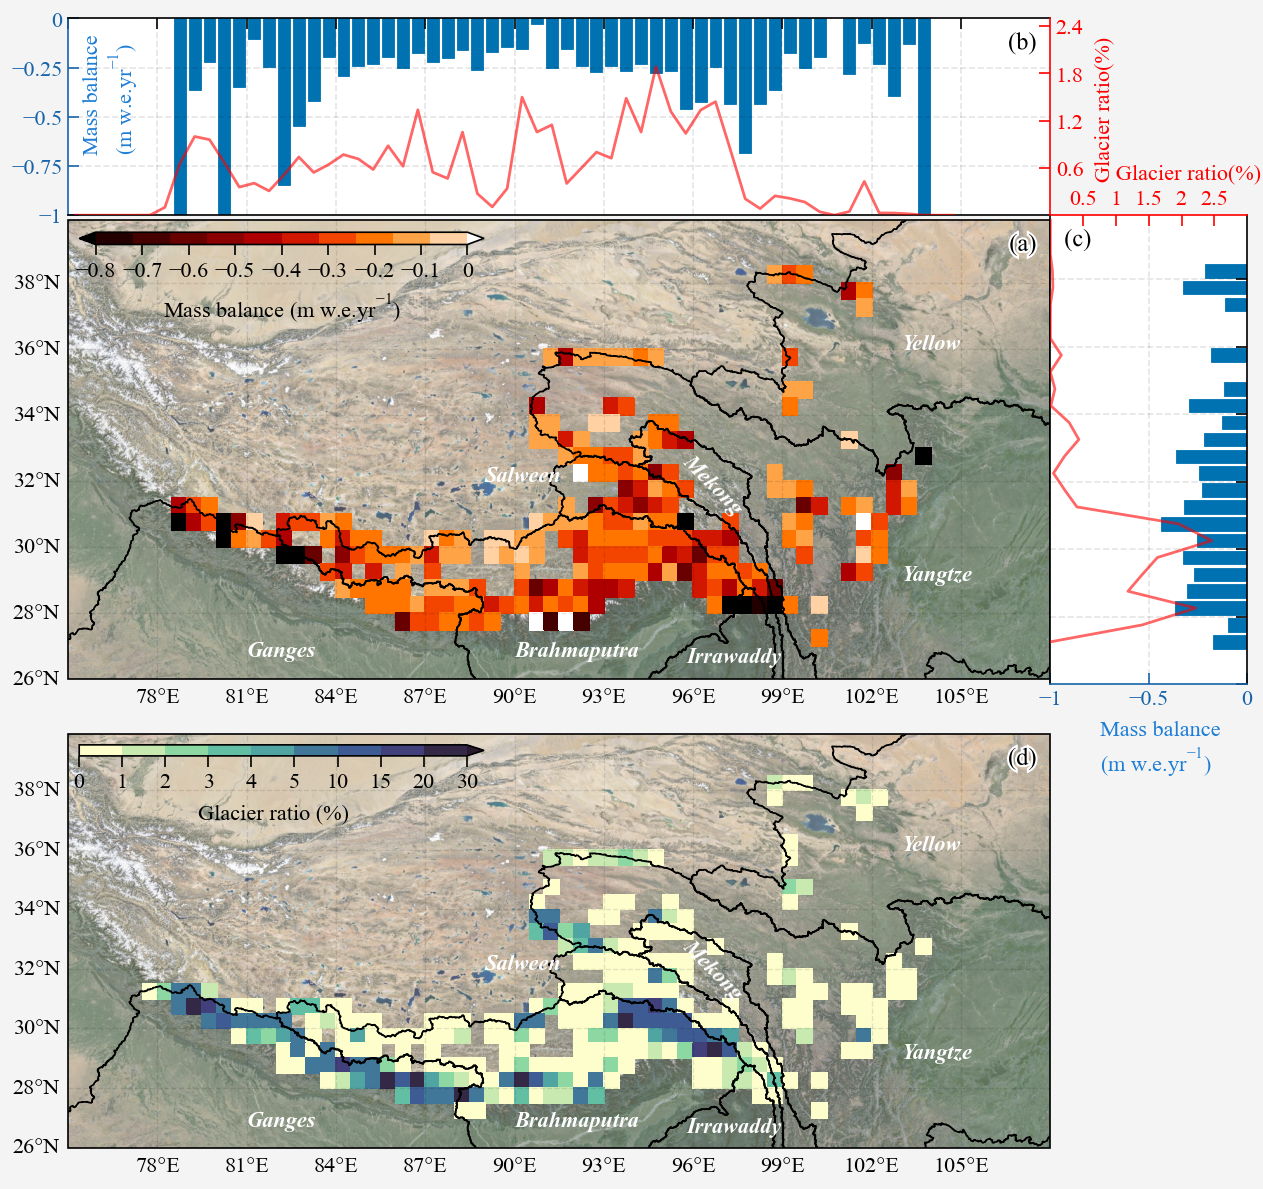

In [85]:
import cartopy
from cartopy.io.img_tiles import Stamen,GoogleTiles
import numpy as np
plot.rc.reset()
plt.rcParams['font.size'] = 8
plt.rcParams['font.sans-serif']='times new roman'
plt.rcParams['grid.linestyle']='--'
#ds_mb.plot()
array = [[1,1,1,1],
         [1,1,1,1],
         [2,2,2,2],
         [2,2,2,2]]
##'16cm','8.98cm'
fig, axs = plot.subplots(array,figsize=('16.05cm','15.11cm'),includepanels=True,
                        proj='cyl',tight=True)
tiler1 =GoogleTiles(style="satellite")
axs.add_image(tiler1,7,alpha=0.7)
axs.format(coast=True, latlines=2, lonlines=3,
           gridlinewidth=0.5,gridlinestyle='--',land=False, ocean=True,rivers=False,
           reso='hi',oceancolor='ocean blue',latlabels='l',lonlabels='b',title='',
           lonlim=(75,108),latlim=(26,39.9)
          )
axs[0].format(urtitle='(a)')
axs[1].format(urtitle='(d)')
########################
sc=axs[1].pcolor(gla_ratio,cmap='Deep',extend='max',vmin=0,levels=[0,1,2,3,4,5,10,15,20,30])
ds_shp.plot(ax=axs[1],facecolor='none',edgecolor='k')
axs[1].colorbar(sc, col=1, loc='ul',length=22,width=0.6,label='Glacier ratio (%)',
                tickminor=False,pad=0.6,frameon=False )
#fig.legend(lines, loc='b', col=1, labels=np.arange(0, len(lines)))
################################
sc=axs[0].pcolor(ds_mb,cmap='gist_heat',extend='both',vmin=-0.8,vmax=0)
axs[0].colorbar(sc, loc='ul',length=22,width=0.6,label='Mass balance (m w.e.yr$^{-1}$)',
                tickminor=False,pad=0.6,frameon=False,ticks=np.arange(-0.8,0.1,0.1))
ds_shp.plot(ax=axs[0],facecolor='none',edgecolor='k')

space='0'
pxsr = axs[0].panel('r', space=space,share=True,width='2.5cm')
pxst = axs[0].panel('t', space=space,share=True,width='2.5cm')

#####################
pxsr.barh(lat_mb.index,lat_mb.values.reshape(-1))
axs1=pxsr.twiny()
axs1.set_zorder(6)
axs1.plot(gla_lat.values.reshape(-1),gla_lat.index,lw=1,color='r',alpha=0.6)
axs1.format(ylim=(26,39.9),tickminor=False,xtickdir='in',ytickdir='in',ylabel='',
            yticklabels=[],xlabel='              Glacier ratio(%)',xcolor='r',
           xticks=[0.5,1,1.5,2,2.5],xlim=(0,3))
pxsr.format(ylim=(26,39.9),tickminor=False,xtickdir='in',ytickdir='in',ylabel='',
            yticklabels=[],xlim=(-1,0),xcolor='blue9',ultitle='(c)')

#########
pxst.bar(lon_mb.index,lon_mb.values.reshape(-1))
axs2=pxst.twinx()
axs2.set_zorder(6)
axs2.plot(gla_lon.index,gla_lon.values.reshape(-1),lw=1,color='r',alpha=0.6)
axs2.format(xlim=(75,108),tickminor=False,xtickdir='in',ytickdir='in',xlabel='',
            xticklabels=[],ylabel='   Glacier ratio(%)',ycolor='r',
           yticks=[0.6,1.2,1.8,2.4],ylim=(0,2.5))
pxst.format(xlim=(75,108),tickminor=False,xtickdir='in',ytickdir='in',xlabel='',
            xticklabels=[],ylim=(-1,0),ycolor='blue9',xticks=range(75,108,3),urtitle='(b)')

pxsr.text(-0.75,23.4,'Mass balance\n(m w.e.yr$^{-1}$)',color='blue7')
pxst.text(75.5,-0.65,'Mass balance\n(m w.e.yr$^{-1}$)',rotation='vertical',color='blue7')
axs.text(81,26.7,'Ganges',fontstyle='italic',fontweight='bold',c='w',fontsize=8)
axs.text(90,26.7,'Brahmaputra',fontstyle='italic',fontweight='bold',c='w',fontsize=8)
axs.text(89,32,'Salween',fontstyle='italic',fontweight='bold',c='w',fontsize=8)
axs.text(95.5,31,'Mekong',fontstyle='italic',fontweight='bold',c='w',fontsize=8,rotation=-45)
axs.text(103,36,'Yellow',fontstyle='italic',fontweight='bold',c='w',fontsize=8)
axs.text(103,29,'Yangtze',fontstyle='italic',fontweight='bold',c='w',fontsize=8)
axs.text(95.8,26.5,'Irrawaddy',fontstyle='italic',fontweight='bold',c='w',fontsize=8)
plt.savefig(pth+'/0Figs_paper/lonlat_0.5-2.tif',dpi=600,bbox_inches='tight')

##### 分流域统计

In [61]:
df_effe_dxt_new.columns

Index(['group_id', 'mean', 'median', 'mean_fill', 'median_fill', 'Glc_Area',
       'Mean_Elev', 'Mean_Slp', 'Mean_Asp', 'MA_Elev', 'basin', 'dh_error',
       'effe_samples', 'mb', 'mb_error', 'dtime', 'dh_propa_err'],
      dtype='object')

In [70]:
df_effe_dxt_new['dh_propa_err'].mean()/df_effe_dxt_new['dtime'].mean()*2

0.1491947679531269

In [75]:
pi=0.85;pw=1;dp=0.06
((((df_effe_dxt_new['mean_fill'].mean()/df_effe_dxt_new['dtime'].mean())*(dp/pw))**2+\
((df_effe_dxt_new['dh_propa_err'].mean()/df_effe_dxt_new['dtime'].mean())*(pi/pw))**2)**0.5)*2

0.13264849342912666

In [36]:
df_effe_dxt_new['mean'].mean()

-9.524962689799008

In [76]:
df_effe_dxt_new['mb']=df_effe_dxt_new['mb'].astype('float')

In [77]:
basin_group=df_effe_dxt_new[['basin','mb', 'mean_fill', 'dh_propa_err', 'dtime','Glc_Area']].groupby('basin')

In [ ]:
# mb_err=(((ds_gla['topo_dh'].mean()/t)*(dp/pw))**2+((ds_gla.attrs['dh error']/t)*(pi/pw))**2)**0.5

In [80]:
pi=0.85;pw=1;dp=0.06
((((basin_group['mean_fill'].mean()/basin_group['dtime'].mean())*(dp/pw))**2+\
((basin_group['dh_propa_err'].mean()/basin_group['dtime'].mean())*(pi/pw))**2)**0.5)*2

basin
Brahmaputra    0.144207
Ganges         0.187162
Irrawaddy      0.559504
Mekong         0.088247
Salween        0.090371
Yangtze        0.071692
Yellow         0.095029
dtype: float64